In [7]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy.signal as signal
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists
from lists import dyads, num_dyads, participants, num_participants

conditions = ["sit","gaze","gaze_swap"]

# Preprocess data

In [8]:
# Set sampling rate for neurokit2
sampling_rate = 2000

In [9]:
# Cosine interpolation
from functions import cosine, rpeaks_cosine_interpolation    

# Pairwise swapping for permutated dyads
def swap_data(data, condition):
    def swappairwise(a): 
        # Based on https://stackoverflow.com/a/30132333
        l = len(a) & ~1
        a[1:l:2], a[:l:2] = a[:l:2], a[1:l:2]
        
    # Create new list
    a = list(range(len(data)))
    a.insert(0, a[-1])
    a.pop()
    
    swappairwise(a) # i.e. 1,2,3,4,5,6 -> 1,6,3,2,5,3,4
    # Iterate through new list
    data_swap = [None]*num_participants
    for i,_ in enumerate(data):
        data_swap[i] = data[a[i]]
        data_swap[i] = np.array(data_swap[i], dtype="float32")
    data_swap = np.array(data_swap)
    # Save files
    np.save(f"data/data_{condition}.npy", data_swap)
    
    return data_swap

In [10]:
# Preprocess function
def preprocess(condition):
    ecg_raw = [None]*num_participants
    ecg = [None]*num_participants
    rpeaks = [None]*num_participants
    data = [None]*num_participants

    # Load data: raw ecgs for 300 s at 1000 Hz
    ecg_raw = np.load(f"data/ecg_raw/ecg_raw_{condition}.npy")

    for i in participants:
        ecg_raw[i] = pd.Series(ecg_raw[i].ravel()) # .ravel() to remove redundant parentheses
        # Clean and normalize data
        ecg[i] = nk.ecg_clean(
            ecg_raw[i], 
            sampling_rate=sampling_rate, 
            method="neurokit")
        # Get R-peaks as a binary time series
        rpeaks[i] = nk.ecg_peaks(
            ecg[i], 
            sampling_rate=sampling_rate)
        rpeaks[i] = rpeaks[i][0]["ECG_R_Peaks"]
        # Trigonometric interpolation of r-peaks
        data[i] = rpeaks_cosine_interpolation(rpeaks[i])
        # Trim data to get rid of nans
        data[i] = data[i][2*sampling_rate:-2*sampling_rate]
        # Downsampling to 50 Hz
        data[i] = data[i][::40]
        data[i] = np.array(data[i], dtype="float32")
    data = np.array(data)
    np.save(f"data/data_{condition}.npy", data)
    return data, ecg, rpeaks


# Quality check
def quality_check(ecg):
    print("ECG quality:")
    for i in participants:
        quality = nk.ecg_quality(
            ecg[i], rpeaks=None, 
            sampling_rate=sampling_rate, 
            method="zhao2018", 
            approach="fuzzy")
        print(f"Person {i} | {quality}")

In [11]:
# Preprocess raw ECG data
ecg = {}
rpeaks = {}
data = {}
conditions = ["sit","gaze"]

for con in conditions:
    data[con], ecg[con], rpeaks[con] = preprocess(con)
    print(f"### {con.upper()} ###")
    print(f"Data shape:", data[con].shape)
    quality_check(ecg[con])
    

### SIT ###
Data shape: (8, 14800)
ECG quality:
Person 0 | Excellent
Person 1 | Barely acceptable
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Barely acceptable
Person 7 | Excellent
### GAZE ###
Data shape: (8, 14800)
ECG quality:
Person 0 | Excellent
Person 1 | Excellent
Person 2 | Excellent
Person 3 | Excellent
Person 4 | Excellent
Person 5 | Excellent
Person 6 | Excellent
Person 7 | Excellent


In [12]:
# Create GAZE-SWAP
data["gaze_swap"] = swap_data(data["gaze"],"gaze_swap")
print("Data shape GAZE-SWAP:", data["gaze_swap"].shape)

# Sanity check for pairwise swapping
np.equal(
    data["gaze"],
    data["gaze_swap"])

Data shape GAZE-SWAP: (8, 14800)


array([[ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False]])

## Plot data

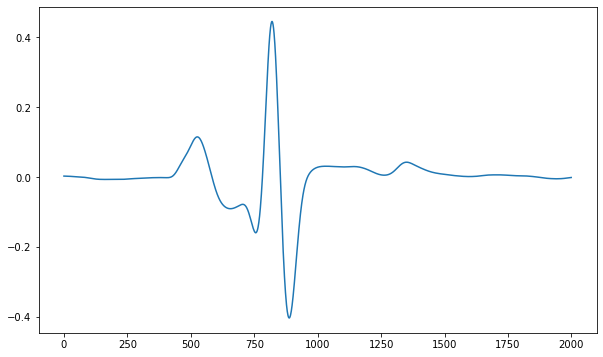

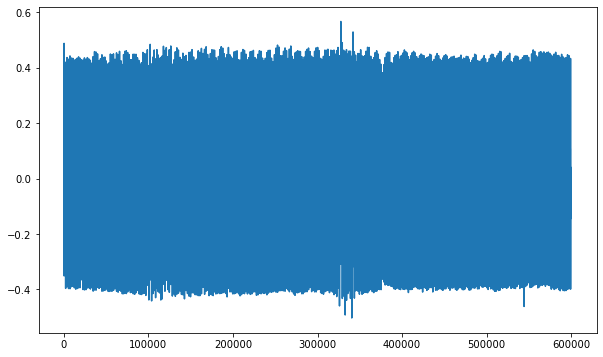

In [13]:
# Show sample data
plt.figure(1)
plt.plot(ecg["sit"][0][0:sampling_rate])

plt.figure(2)
plt.plot(ecg["gaze"][0])

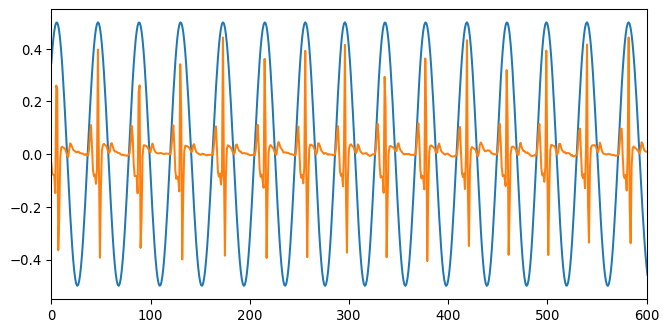

In [14]:
xlim1 = 0*sampling_rate/40
xlim2 = 24*sampling_rate/40

fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2/2)

plt.plot(data["sit"][0])
plt.plot(ecg["sit"][0][2*sampling_rate::40])

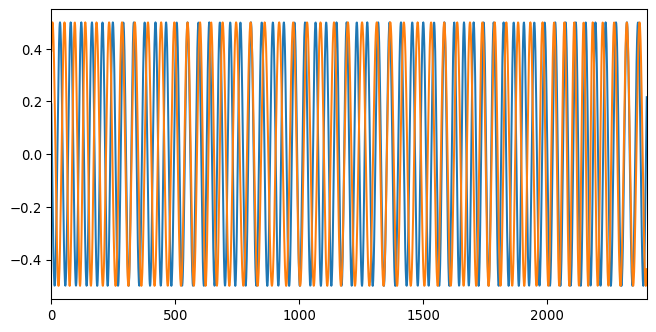

In [15]:
fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2*2)
test = np.array(data["gaze"][0])

plt.plot(data["gaze"][0])
plt.plot(data["gaze"][1])